# Description:

This notebook is calulating the ODE for the nine mode model created by Eckhardt et. al.:

**A low-dimensional model for turbulent shear flows**
https://iopscience.iop.org/article/10.1088/1367-2630/6/1/056

In [47]:
from IPython.display import display

import re
import glob
import numpy as np
import pandas as pd
import os
import itertools
import pickle
from tqdm.notebook import tqdm
from multiprocessing import Pool


import sympy
from sympy import Function
from sympy import integrate
from sympy import simplify, trigsimp
from sympy import symbols, Symbol, Matrix, integrate
from sympy import sin, cos, sqrt, pi
from sympy.vector import gradient

# you can remove that line if you sure
# another sympy version has no
# relevant changes in syntax
assert sympy.__version__ == '1.5.1'

# Set up folderstucture

In [33]:
for p in ["expressions/I1","expressions/I2","expressions/I3"]:
    if not os.path.isdir(p):
        os.makedirs(p)

# Define variables and constants

In [3]:
x, y, z = symbols('x y z')

a = Symbol(r'\alpha', nonzero=True,finite=True)
b = Symbol(r'\beta', nonzero=True,finite=True)
g = Symbol(r'\gamma', nonzero=True,finite=True)

# Navier Stokes solver

we solve the NSE in three steps:

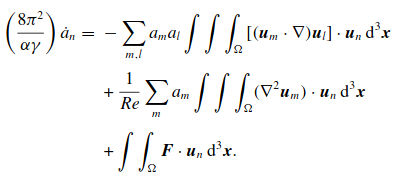

In [38]:
def calc_I1(um, ul, un):
    
    dx_ulx = ul[0].diff(x)
    dy_ulx = ul[0].diff(y)
    dz_ulx = ul[0].diff(z)
    
    dx_uly = ul[1].diff(x)
    dy_uly = ul[1].diff(y)
    dz_uly = ul[1].diff(z)
    
    dx_ulz = ul[2].diff(x)
    dy_ulz = ul[2].diff(y)
    dz_ulz = ul[2].diff(z)
    
    temp_vector = Matrix([
                         [um[0] * dx_ulx + um[1] * dy_ulx + um[2] * dz_ulx],
                         [um[0] * dx_uly + um[1] * dy_uly + um[2] * dz_uly],
                         [um[0] * dx_ulz + um[1] * dy_ulz + um[2] * dz_ulz]
                         ])
    
    return temp_vector.dot(un)


def calc_I2(um, un):
    
    temp_vector = Matrix([
                         [um[0].diff(x,2)],
                         [um[1].diff(y,2)],
                         [um[2].diff(z,2)]
                         ])

    return temp_vector.dot(un)


def calc_I3(un, force):
    return force.dot(un)


def integrate_over_volumne(exp):
    return integrate(exp,(x, 0, 2*pi/a),(y, -1, 1),(z, 0, 2*pi/g))

# Define the nine modes and the driving force

In [5]:
force = Matrix([
               [0],
               [0],
               [0]
               ])

In [6]:
u1 = Matrix([
            [sqrt(2)*sin(pi * y/2)],
            [0],
            [0]
            ])

u2 = Matrix([
            [4/sqrt(3)*cos(pi * y/2)**2 * cos(g*z)],
            [0],
            [0]
            ])

u3 = Matrix([
            [0],
            [2*g*cos(pi*y/2)*cos(g*z)],
            [pi*sin(pi*y/2)*sin(g*z)]
            ])

u3 *= 2/sqrt(4*g**2 + pi**2)

u4 = Matrix([
            [0],
            [0],
            [4/sqrt(3)*cos(a*x)*cos(pi*y/2)**2]
            ])


u5 = Matrix([
            [0],
            [0],
            [2*sin(a*x)*sin(pi*y/2)]
            ])

u6 = Matrix([
            [-g*cos(a*x)* cos(pi*y/2)**2 * sin(g*z)],
            [0],
            [a*sin(a*x)*cos(pi*y/2)**2*cos(g*z)]
            ])

u6 *= 2*sqrt(2)/sqrt(3*(a**2+g**2))

u7 = Matrix([
            [g*sin(a*x)*sin(pi*y/2)*sin(g*z)],
            [0],
            [a*cos(a*x)*sin(pi*y/2)*cos(g*z)]
            ])

u7 *= 2*sqrt(2)/sqrt(a**2+g**2)

u8 = Matrix([
            [pi*a*sin(a*x)*sin(pi*y/2)*sin(g*z)],
            [2*(a**2+g**2)*cos(a*x)*cos(pi*y/2)*sin(g*z)],
            [-pi*g*cos(a*x)*sin(pi*y/2)*cos(g*z)]
            ])

u8 *= 2*sqrt(2)/sqrt((a**2+g**2)*(4*a**2+4*g**2+pi**2))

u9 = Matrix([
            [sqrt(2)*sin(3*pi*y/2)],
            [0],
            [0]
            ])

list_of_u = [u1,u2,u3,u4,u5,u6,u7,u8,u9]

# Check if the modes are divergenz free

In [7]:
def divergence(f, x):
    return sum(fi.diff(xi) for fi, xi in zip(f, x))

for u in list_of_u:
    div = divergence(u, [x,y,z])
    div = simplify(div)
    div = trigsimp(div)
    display(div)

0

0

0

0

0

0

0

0

0

# Display the modes

In [8]:
for u in list_of_u:
    display(u)

Matrix([
[sqrt(2)*sin(pi*y/2)],
[                  0],
[                  0]])

Matrix([
[4*sqrt(3)*cos(pi*y/2)**2*cos(\gamma*z)/3],
[                                       0],
[                                       0]])

Matrix([
[                                                           0],
[4*\gamma*cos(pi*y/2)*cos(\gamma*z)/sqrt(4*\gamma**2 + pi**2)],
[    2*pi*sin(pi*y/2)*sin(\gamma*z)/sqrt(4*\gamma**2 + pi**2)]])

Matrix([
[                                       0],
[                                       0],
[4*sqrt(3)*cos(pi*y/2)**2*cos(\alpha*x)/3]])

Matrix([
[                          0],
[                          0],
[2*sin(pi*y/2)*sin(\alpha*x)]])

Matrix([
[-2*sqrt(2)*\gamma*sin(\gamma*z)*cos(pi*y/2)**2*cos(\alpha*x)/sqrt(3*\alpha**2 + 3*\gamma**2)],
[                                                                                           0],
[ 2*sqrt(2)*\alpha*sin(\alpha*x)*cos(pi*y/2)**2*cos(\gamma*z)/sqrt(3*\alpha**2 + 3*\gamma**2)]])

Matrix([
[2*sqrt(2)*\gamma*sin(pi*y/2)*sin(\alpha*x)*sin(\gamma*z)/sqrt(\alpha**2 + \gamma**2)],
[                                                                                   0],
[2*sqrt(2)*\alpha*sin(pi*y/2)*cos(\alpha*x)*cos(\gamma*z)/sqrt(\alpha**2 + \gamma**2)]])

Matrix([
[                  2*sqrt(2)*pi*\alpha*sin(pi*y/2)*sin(\alpha*x)*sin(\gamma*z)/(sqrt(\alpha**2 + \gamma**2)*sqrt(4*\alpha**2 + 4*\gamma**2 + pi**2))],
[2*sqrt(2)*(2*\alpha**2 + 2*\gamma**2)*sin(\gamma*z)*cos(pi*y/2)*cos(\alpha*x)/(sqrt(\alpha**2 + \gamma**2)*sqrt(4*\alpha**2 + 4*\gamma**2 + pi**2))],
[                 -2*sqrt(2)*pi*\gamma*sin(pi*y/2)*cos(\alpha*x)*cos(\gamma*z)/(sqrt(\alpha**2 + \gamma**2)*sqrt(4*\alpha**2 + 4*\gamma**2 + pi**2))]])

Matrix([
[sqrt(2)*sin(3*pi*y/2)],
[                    0],
[                    0]])

# Calculate all non-liniaritys

In [9]:
def wrapper(indices):
    
    m,l,n = indices
    
    out_path = "expressions/I1/I1_m={}_l={}_n={}.pkl".format(m,l,n)
    
    if not os.path.isfile(out_path):
    
        nonlin = calc_I1(list_of_u[m],list_of_u[l],list_of_u[n])
        nonlin = simplify(nonlin)
        nonlin = trigsimp(nonlin)

        integral = integrate_over_volumne(nonlin)
        integral = simplify(integral)
        integral = trigsimp(integral) 

        with open(out_path, "w") as outf:
            pickle.dump(integral, outf)
    
    
# List all the differnt permutations for the indices
todolist = [p for p in itertools.product(range(9), repeat=3)]
todolist = todolist[:]


print("Jobs to do: {}".format(len(todolist)))

# # Run jobs on one thread
# for item in tqdm(todolist):
#     wrapper(item)

# do the calculations in parallel
pool = Pool(processes=8)
for _ in tqdm(pool.imap_unordered(wrapper, todolist), total=len(todolist)):
    pass

Jobs to do: 729


# Check Couplings

Compare to **Table 1** in 

**A low-dimensional model for turbulent shear flows**
https://iopscience.iop.org/article/10.1088/1367-2630/6/1/056

In [28]:
all_couplings = glob.glob("expressions/I1/*.pkl")

table = np.zeros((9,9,9))

for coupling in all_couplings:

    # get the indices from the filename 
    
    match = re.search("m=(\d+)",coupling)
    m = int(match.group(1))
    
    match = re.search("l=(\d+)",coupling)
    l = int(match.group(1))
    
    match = re.search("n=(\d+)",coupling)
    n = int(match.group(1))
    

    with open(coupling) as inf:
        out = pickle.load(inf)

    if out != 0:
        table[m,l,n] += 1

        
df = pd.DataFrame(table.tolist())
df = df.applymap(np.nonzero)
df = df.applymap(lambda x: ', '.join(str(xx) for xx in x[0]))
df

,0,1,2,3,4,5,6,7,8
0,,,,4,3,6,5,,
1,,,,5,"6, 7",3,4,4,
2,1,"0, 8",,"6, 7",5,4,3,3,1
3,,5,"6, 7",,,1,2,2,
4,,"6, 7",5,,,2,1,1,
5,,,4,,2,,,,
6,,,3,2,,,,,
7,5,,3,2,,"0, 8",,,5
8,,,,4,3,6,5,,


In [82]:
def wrapper(indices):
    
    m,n = indices
    
    out_path = "expressions/I2/I2_m={}_n={}.pkl".format(m,l,n)
    
    if not os.path.isfile(out_path):
    
        diffusion = calc_I2(list_of_u[m],list_of_u[n])
        diffusion = simplify(diffusion)
        diffusion = trigsimp(diffusion)

        integral = integrate_over_volumne(diffusion)
        integral = simplify(integral)
        integral = trigsimp(integral) 

        with open(out_path, "w") as outf:
            pickle.dump(integral, outf)
    
    
# List all the differnt permutations for the indices
todolist = [p for p in itertools.product(range(9), repeat=2)]

print("Jobs to do: {}".format(len(todolist)))

# # Run jobs on one thread
# for item in tqdm(todolist):
#     wrapper(item)

# do the calculations in parallel
pool = Pool(processes=8)
for _ in tqdm(pool.imap_unordered(wrapper, todolist), total=len(todolist)):
    pass

Jobs to do: 81


In [86]:
def wrapper(indices):
    
    n = indices
    
    out_path = "expressions/I3/I3_n={}.pkl".format(m,l,n)
    
    if not os.path.isfile(out_path):
    
        diffusion = calc_I3(list_of_u[n],force)
        diffusion = simplify(diffusion)
        diffusion = trigsimp(diffusion)

        integral = integrate_over_volumne(diffusion)
        integral = simplify(integral)
        integral = trigsimp(integral) 

        with open(out_path, "w") as outf:
            pickle.dump(integral, outf)
    
    
# List all the differnt permutations for the indices
todolist = range(9)

print("Jobs to do: {}".format(len(todolist)))

# # Run jobs on one thread
# for item in tqdm(todolist):
#     wrapper(item)

# do the calculations in parallel
pool = Pool(processes=8)
for _ in tqdm(pool.imap_unordered(wrapper, todolist), total=len(todolist)):
    pass

Jobs to do: 9


# Build the equations

In [84]:
Re = Symbol("Re")

a1 = Symbol("a1")
a2 = Symbol("a2")
a3 = Symbol("a3")
a4 = Symbol("a4")
a5 = Symbol("a5")
a6 = Symbol("a6")
a7 = Symbol("a7")
a8 = Symbol("a8")
a9 = Symbol("a9")

list_of_a = [a1,a2,a3,a4,a5,a6,a7,a8,a9]

In [70]:
C = a*g/(8*pi**2)
C

\alpha*\gamma/(8*pi**2)

In [87]:
odes = []

for n in range(9):

    ode = 0
    
    
    # build the nonlinear part
    for m,l in [p for p in itertools.product(range(9), repeat=2)]:
        
        path = "expressions/I1/I1_m={}_l={}_n={}.pkl".format(m,l,n)
        with open(path) as inf:
            X = pickle.load(inf) 
            
        ode += -C *list_of_a[m] * list_of_a[l] * X
    
    
    
    # build the linear part
    for m in range(9):
        
        path = "expressions/I2/I2_m={}_n={}.pkl".format(m,l,n)
        with open(path) as inf:
            X = pickle.load(inf) 
            
        ode += 1/Re * C *list_of_a[m] * X
        
        
    
    # add the force coupling
    path = "expressions/I3/I3_n={}.pkl".format(m,l,n)
    with open(path) as inf:
        X = pickle.load(inf) 

    ode += C * X
    
    
    odes.append(ode)
        


In [90]:
for ode in odes:
    display(ode)
    print(3*"\n")

sqrt(6)*pi*\gamma*a2*a3/(2*sqrt(4*\gamma**2 + pi**2)) - sqrt(6)*pi*\gamma*a6*a8*(\alpha**2 + \gamma**2)/(4*sqrt(4*\alpha**6 + 12*\alpha**4*\gamma**2 + pi**2*\alpha**4 + 12*\alpha**2*\gamma**4 + 2*pi**2*\alpha**2*\gamma**2 + 4*\gamma**6 + pi**2*\gamma**4))

-sqrt(6)*pi*\alpha*\gamma*a5*a8/(6*sqrt(4*\alpha**4 + 8*\alpha**2*\gamma**2 + pi**2*\alpha**2 + 4*\gamma**4 + pi**2*\gamma**2)) + 5*sqrt(6)*\gamma**2*a4*a6/(18*sqrt(\alpha**2 + \gamma**2)) - sqrt(6)*\gamma**2*a5*a7/(6*sqrt(\alpha**2 + \gamma**2)) - sqrt(6)*pi*\gamma*a1*a3/(2*sqrt(4*\gamma**2 + pi**2)) - sqrt(6)*pi*\gamma*a3*a9/(2*sqrt(4*\gamma**2 + pi**2))

sqrt(6)*pi*\alpha*\gamma*a4*a7/(3*sqrt(\alpha**2 + \gamma**2)*sqrt(4*\gamma**2 + pi**2)) + sqrt(6)*pi*\alpha*\gamma*a5*a6/(6*sqrt(\alpha**2 + \gamma**2)*sqrt(4*\gamma**2 + pi**2)) - sqrt(6)*\gamma**2*a4*a8*(12*\alpha**2 + 12*\gamma**2 + pi**2)/(6*sqrt(16*\alpha**4*\gamma**2 + 4*pi**2*\alpha**4 + 32*\alpha**2*\gamma**4 + 12*pi**2*\alpha**2*\gamma**2 + pi**4*\alpha**2 + 16*\gamma**6 + 8*pi**2*\gamma**4 + pi**4*\gamma**2)) + sqrt(6)*pi**2*a4*a8*(4*\alpha**2 + 8*\gamma**2/3)/(8*sqrt(16*\alpha**4*\gamma**2 + 4*pi**2*\alpha**4 + 32*\alpha**2*\gamma**4 + 12*pi**2*\alpha**2*\gamma**2 + pi**4*\alpha**2 + 16*\gamma**6 + 8*pi**2*\gamma**4 + pi**4*\gamma**2))

-5*sqrt(6)*\alpha**2*a2*a6/(18*sqrt(\alpha**2 + \gamma**2)) - sqrt(6)*pi*\alpha*\gamma*a3*a7/(2*sqrt(\alpha**2 + \gamma**2)*sqrt(4*\gamma**2 + pi**2)) - sqrt(6)*\alpha*a1*a5/6 - sqrt(6)*\alpha*a5*a9/6 + sqrt(6)*pi**2*\gamma**2*a3*a8/(3*sqrt(16*\alpha**4*\gamma**2 + 4*pi**2*\alpha**4 + 32*\alpha**2*\gamma**4 + 12*pi**2*\alpha**2*\gamma**2 + pi**4*\alpha**2 + 16*\gamma**6 + 8*pi**2*\gamma**4 + pi**4*\gamma**2)) - sqrt(6)*pi**2*a3*a8*(4*\alpha**2 + 8*\gamma**2/3)/(8*sqrt(16*\alpha**4*\gamma**2 + 4*pi**2*\alpha**4 + 32*\alpha**2*\gamma**4 + 12*pi**2*\alpha**2*\gamma**2 + pi**4*\alpha**2 + 16*\gamma**6 + 8*pi**2*\gamma**4 + pi**4*\gamma**2))

sqrt(6)*\alpha**2*a2*a7/(6*sqrt(\alpha**2 + \gamma**2)) - sqrt(6)*pi*\alpha*\gamma*a2*a8/(6*sqrt(4*\alpha**4 + 8*\alpha**2*\gamma**2 + pi**2*\alpha**2 + 4*\gamma**4 + pi**2*\gamma**2)) + sqrt(6)*pi*\alpha*\gamma*a3*a6/(6*sqrt(\alpha**2 + \gamma**2)*sqrt(4*\gamma**2 + pi**2)) + sqrt(6)*\alpha*a1*a4/6 + sqrt(6)*\alpha*a4*a9/6

5*sqrt(6)*\alpha**2*a2*a4/(18*sqrt(\alpha**2 + \gamma**2)) - sqrt(6)*pi*\alpha*\gamma*a3*a5/(3*sqrt(\alpha**2 + \gamma**2)*sqrt(4*\gamma**2 + pi**2)) + sqrt(6)*\alpha*a1*a7*(\alpha**2 + \gamma**2)/(12*sqrt(\alpha**4 + 2*\alpha**2*\gamma**2 + \gamma**4)) + sqrt(6)*\alpha*a7*a9*(\alpha**2 + \gamma**2)/(12*sqrt(\alpha**4 + 2*\alpha**2*\gamma**2 + \gamma**4)) - 5*sqrt(6)*\gamma**2*a2*a4/(18*sqrt(\alpha**2 + \gamma**2)) + sqrt(6)*pi*\gamma*a1*a8*(\alpha**2 + \gamma**2)/(4*sqrt(4*\alpha**6 + 12*\alpha**4*\gamma**2 + pi**2*\alpha**4 + 12*\alpha**2*\gamma**4 + 2*pi**2*\alpha**2*\gamma**2 + 4*\gamma**6 + pi**2*\gamma**4)) + sqrt(6)*pi*\gamma*a8*a9*(\alpha**2 + \gamma**2)/(4*sqrt(4*\alpha**6 + 12*\alpha**4*\gamma**2 + pi**2*\alpha**4 + 12*\alpha**2*\gamma**4 + 2*pi**2*\alpha**2*\gamma**2 + 4*\gamma**6 + pi**2*\gamma**4))

-sqrt(6)*\alpha**2*a2*a5/(6*sqrt(\alpha**2 + \gamma**2)) + sqrt(6)*pi*\alpha*\gamma*a3*a4/(6*sqrt(\alpha**2 + \gamma**2)*sqrt(4*\gamma**2 + pi**2)) - sqrt(6)*\alpha*a1*a6*(\alpha**2 + \gamma**2)/(12*sqrt(\alpha**4 + 2*\alpha**2*\gamma**2 + \gamma**4)) - sqrt(6)*\alpha*a6*a9*(\alpha**2 + \gamma**2)/(12*sqrt(\alpha**4 + 2*\alpha**2*\gamma**2 + \gamma**4)) + sqrt(6)*\gamma**2*a2*a5/(6*sqrt(\alpha**2 + \gamma**2))

sqrt(6)*pi*\alpha*\gamma*a2*a5/(3*sqrt(4*\alpha**4 + 8*\alpha**2*\gamma**2 + pi**2*\alpha**2 + 4*\gamma**4 + pi**2*\gamma**2)) + sqrt(6)*\gamma**2*a3*a4*(12*\alpha**2 + 12*\gamma**2 + pi**2)/(6*sqrt(16*\alpha**4*\gamma**2 + 4*pi**2*\alpha**4 + 32*\alpha**2*\gamma**4 + 12*pi**2*\alpha**2*\gamma**2 + pi**4*\alpha**2 + 16*\gamma**6 + 8*pi**2*\gamma**4 + pi**4*\gamma**2)) - sqrt(6)*pi**2*\gamma**2*a3*a4/(3*sqrt(16*\alpha**4*\gamma**2 + 4*pi**2*\alpha**4 + 32*\alpha**2*\gamma**4 + 12*pi**2*\alpha**2*\gamma**2 + pi**4*\alpha**2 + 16*\gamma**6 + 8*pi**2*\gamma**4 + pi**4*\gamma**2))

sqrt(6)*pi*\gamma*a2*a3/(2*sqrt(4*\gamma**2 + pi**2)) - sqrt(6)*pi*\gamma*a6*a8*(\alpha**2 + \gamma**2)/(4*sqrt(4*\alpha**6 + 12*\alpha**4*\gamma**2 + pi**2*\alpha**4 + 12*\alpha**2*\gamma**4 + 2*pi**2*\alpha**2*\gamma**2 + 4*\gamma**6 + pi**2*\gamma**4))

In [64]:
ode = 0

In [65]:
ode += list_of_a[0]

TypeError: unsupported operand type(s) for +=: 'int' and 'UndefinedFunction'

In [68]:
a1*a2

TypeError: unsupported operand type(s) for *: 'UndefinedFunction' and 'UndefinedFunction'